Emanuel Pacheco (2024138898)

Filipe Obrist (2024170686)

Ivo Simões (2024160048)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Active Learning imports
from modAL.disagreement import vote_entropy_sampling
from modAL.uncertainty import entropy_sampling
from modAL.models import ActiveLearner, Committee

# Explainability imports
import shap

# Machine Learning imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_confusion_matrix

# Reproducibility
SEED = 42
np.random.seed(SEED)

c:\Users\emanu\anaconda3\envs\IACH\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_SIZE = 0.1
ESTIMATORS = 100
BATCH_SIZES = [1, 3, 5, 10]  # Note: Changing this might cause conflict with explainability
ABSTENTION_THRESHOLD = 0.75  # Between 0.5 (random) and 1.0 (absolutely certain)
EPOCHS = 210  # Active Learning: number of samples to be labeled in querying
N_MEMBERS = 5  # Number of comittee members

# Data Preparation 

In [4]:
# Load dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')
df

gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140         0  
1              6.6                   80         0  
2              5.7                  158         0  
3              5.0                  155         0  
4              4.8                  155         0  
...            ...                  ...       ...  
99995          6.2                   90         0  
99996          6.5                  100         0  
99997          5.7                  155         0  
99998          4.0                  100         0  
99999          6.6                   90         0  

[100000 rows x 9 columns]

In [5]:
# Reduce dataset size
df = df.sample(n=20000, random_state=SEED)
df

gender   age  hypertension  heart_disease smoking_history    bmi  \
75721  Female  13.0             0              0         No Info  20.82   
80184  Female   3.0             0              0         No Info  21.00   
19864    Male  63.0             0              0          former  25.32   
76699  Female   2.0             0              0           never  17.43   
92991  Female  33.0             0              0     not current  40.08   
...       ...   ...           ...            ...             ...    ...   
32595  Female  44.0             0              0     not current  21.95   
29313    Male  61.0             1              0          former  41.98   
37862  Female  49.0             0              0           never  26.51   
53421    Male  73.0             0              1         No Info  27.32   
42410  Female  43.0             0              0           never  23.86   

       HbA1c_level  blood_glucose_level  diabetes  
75721          5.8                  126         0  
80184          5.0                  145         0  
19864          3.5                  200         0  
76699          6.1                  126         0  
92991          6.2                  200         1  
...            ...                  ...       ...  
32595          6.0                  159         0  
29313          3.5                   90         0  
37862          4.8                  100         0  
53421          6.6                  100         0  
42410          5.8                  145         0  

[20000 rows x 9 columns]

In [6]:
# Remove duplicates
duplicates = df[df.duplicated()]
print(f"Amount of duplicate entries: {duplicates.shape[0]}")
df = df.drop_duplicates()

Amount of duplicate entries: 193


In [7]:
# Missing values (check if all are not null)
(~df.isnull()).all()

gender                 True
age                    True
hypertension           True
heart_disease          True
smoking_history        True
bmi                    True
HbA1c_level            True
blood_glucose_level    True
diabetes               True
dtype: bool

In [8]:
# Unique values of each feature
for column in df.columns:
    print(f"{column}: {len(pd.unique(df[column]))} unique values (type: {df[column].dtype})")

gender: 3 unique values (type: object)
age: 102 unique values (type: float64)
hypertension: 2 unique values (type: int64)
heart_disease: 2 unique values (type: int64)
smoking_history: 6 unique values (type: object)
bmi: 3204 unique values (type: float64)
HbA1c_level: 18 unique values (type: float64)
blood_glucose_level: 18 unique values (type: int64)
diabetes: 2 unique values (type: int64)


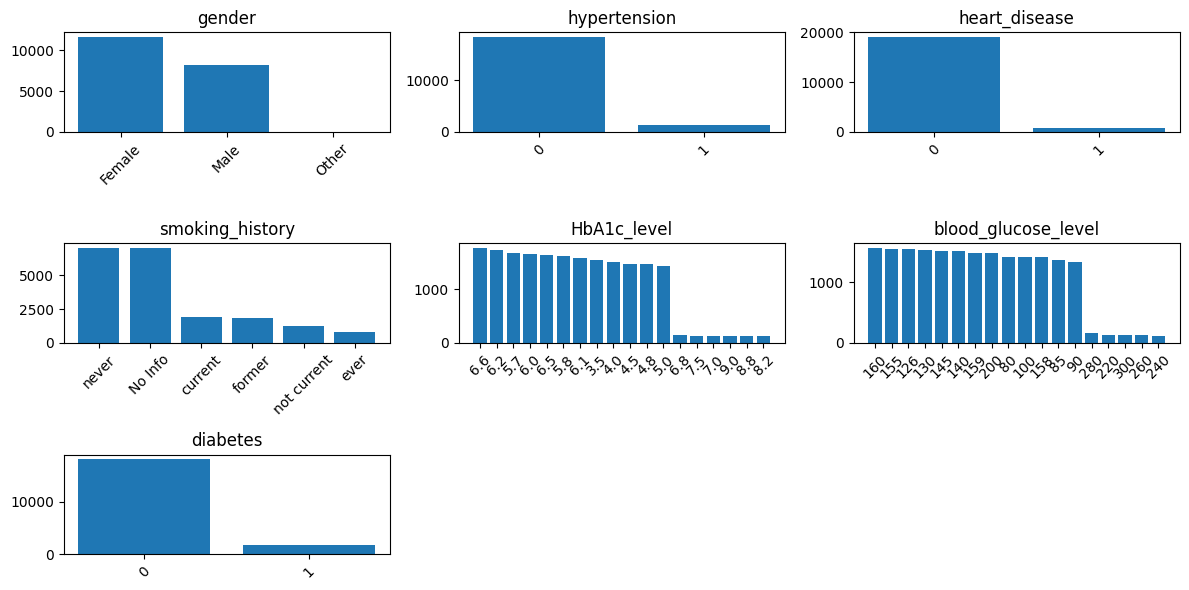

In [9]:
''' GPT aided '''

# Plot histograms of low value count features (few unique values)
df2 = df[['gender', 'hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'blood_glucose_level', 'diabetes']]

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 6))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot histograms for each column
for i, col in enumerate(df2.columns):
    value_counts = df2[col].value_counts()
    axes[i].bar(value_counts.index.astype(str), value_counts.values)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
# Label distribution
df['diabetes'].value_counts()

diabetes
0    18099
1     1708
Name: count, dtype: int64

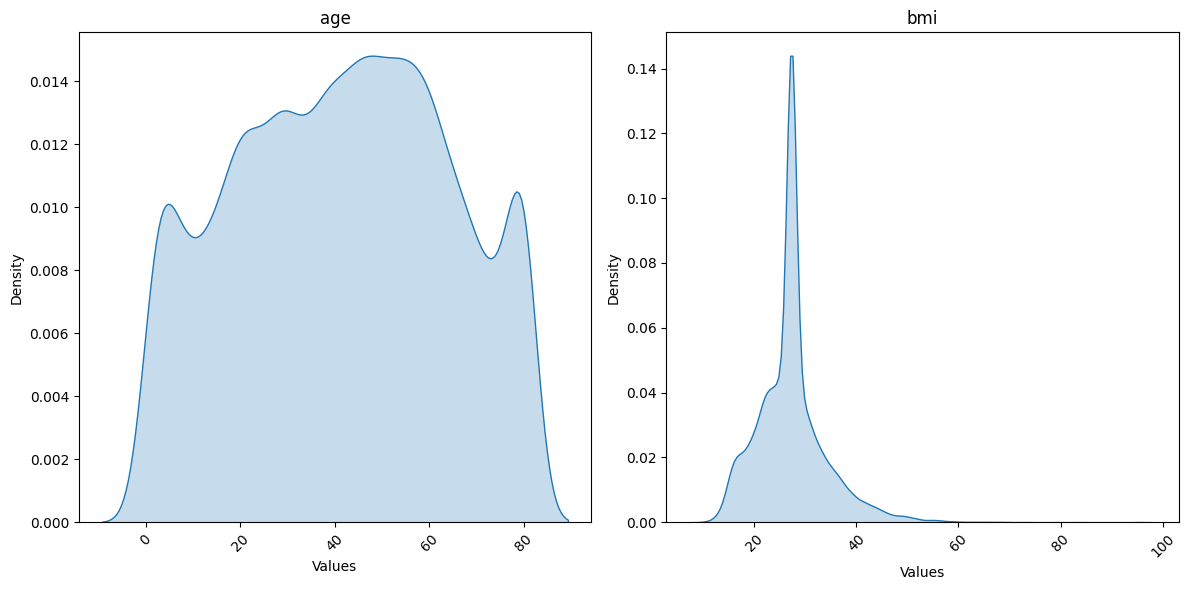

In [11]:
''' GPT aided '''
# Plot a KDE (kernel density estimate) of high value count features (many unique values)
df2 = df[['age', 'bmi']]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot KDE for each column
for i, col in enumerate(df2.columns):
    value_counts = df2[col].value_counts()
    sns.kdeplot(df[col], ax=axes[i], fill=True)
    axes[i].set_title(col)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
# Eliminate entries with 'Other' in gender due to massive under-representation
df = df[df['gender'] != 'Other']
df.shape

(19805, 9)

In [13]:
# Encode categorical values
encoder = LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])
df['smoking_history'] = encoder.fit_transform(df['smoking_history'])

X = df.iloc[:, :-1].values # All columns except the last
y = df.iloc[:, -1].values  # The last column is the target

# Passive Learning

Accuracy = 0.974 | Precision = 0.984 | Recall = 0.713


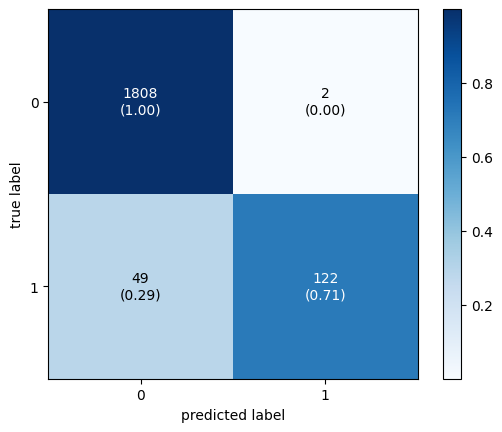

In [14]:
# Train test split (for passive learning)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)

# Passive learner
rf = RandomForestClassifier(n_estimators=ESTIMATORS, random_state=SEED)

# Learn the model and make predictions
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

# Measure accuracy, precision and 
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
print(f"Accuracy = {acc:.3f} | Precision = {prec:.3f} | Recall = {recall:.3f}")

# Visualize a confusion matrix for the predictions
plot_confusion_matrix(confusion_matrix(y_test, preds),
                      colorbar=True,
                      show_absolute=True,
                      show_normed=True)
plt.show()

## Explainability

In [15]:
shap.initjs()

In [16]:
# Create a dataframe with test set metadata
df_test = pd.DataFrame(X_test, columns=df.columns[:-1])

# Explainer interface for explaining the passive learning model through Shapley values
explainer = shap.TreeExplainer(rf)

# Obtain an explanation for the test dataset (SHAP values)
shap_values = explainer(df_test)

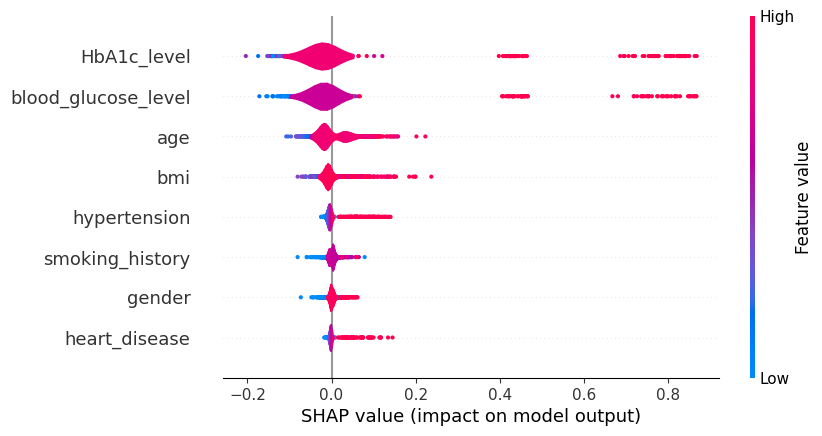

In [17]:
# Plotting feature importance
shap.plots.violin(shap_values.values[..., 1], features=df_test, feature_names=df_test.columns)

In [18]:
# Get the indices of the test samples with class 1
class1_idx = np.where(y_test == 1)[0]

# Create a dataframe with test set metadata for class 1 samples
df_test_1 = pd.DataFrame(X_test[class1_idx], columns=df.columns[:-1])

# Explain the passive learning model's predictions through SHAP values
shap_values_1 = explainer(df_test_1)

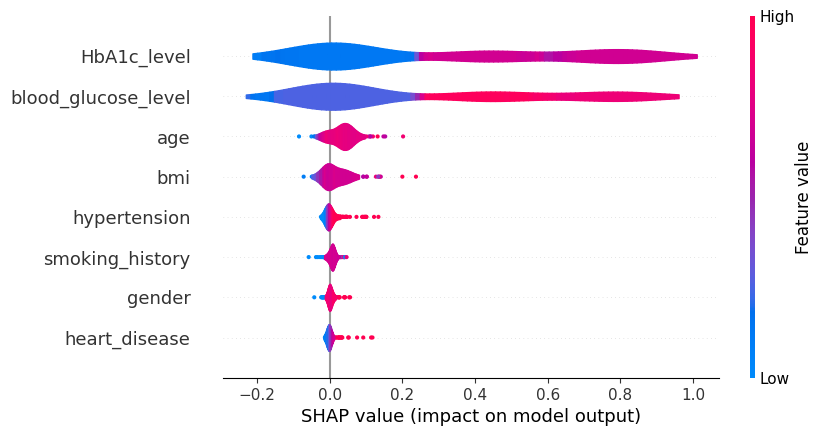

In [19]:
# Plotting feature importance
shap.plots.violin(shap_values_1.values[..., 1], features=df_test_1, feature_names=df_test_1.columns)

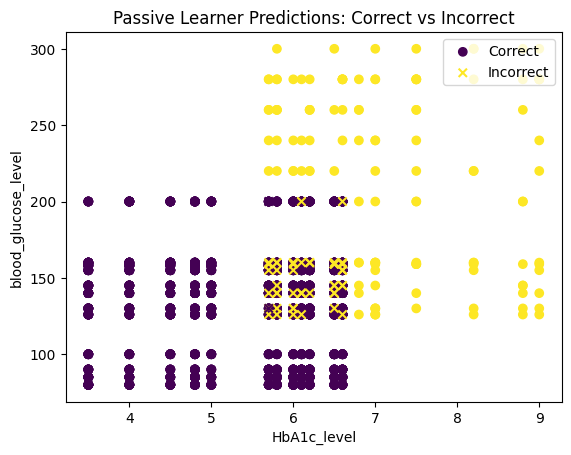

In [20]:
''' GPT aided '''

# Get the 2 "most important features"
X_test_2d = X_test[:, -2:]

# Identify correctly and incorrectly classified samples
correct = preds == y_test
incorrect = preds != y_test

# Plot the correctly classified examples (ticks)
plt.scatter(
    X_test_2d[correct, 0], X_test_2d[correct, 1],
    c=y_test[correct],
    marker='o',  # Circle for correct
    label='Correct'
)

# Plot the incorrectly classified examples (crosses)
plt.scatter(
    X_test_2d[incorrect, 0], X_test_2d[incorrect, 1],
    c=y_test[incorrect],
    marker='x',  # Cross for incorrect
    label='Incorrect'
)

# Add labels, legend, and title
plt.xlabel('HbA1c_level')
plt.ylabel('blood_glucose_level')
plt.title('Passive Learner Predictions: Correct vs Incorrect')
plt.legend(loc='upper right')
plt.show()

In [21]:
# Plotting prediction explanation
shap.plots.force(explainer.expected_value[0], shap_values.values[..., 1], X_test, feature_names=df_test.columns)

# Active Learning without Abstention - Entropy Sampling

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)

accuracy_final = []
precision_final = []
recall_final = []
epoch_final = []
learner1_list = []

for batch_size in tqdm(BATCH_SIZES):
    epoch = EPOCHS // batch_size
    X_init, X_pool, y_init, y_pool = train_test_split(X_train, y_train, test_size=(len(X_train)-20)/len(X_train), random_state=SEED, stratify=y_train)

    learner = ActiveLearner(
            estimator=RandomForestClassifier(n_estimators=ESTIMATORS, random_state=SEED),
            query_strategy=entropy_sampling,
            X_training=X_init, y_training=y_init
            )
    
    predictions = learner.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions)

    accuracy_scores = [acc]
    precision_scores = [precision]
    recall_scores = [recall]
    epochs = [1]

    for i in range(2, epoch+1):
        query_idx, query_instances = learner.query(X_pool, n_instances=batch_size)

        # Retrieve batch of samples and train the model on them
        y_batch = y_pool[query_idx]
        learner.teach(X=query_instances, y=y_batch)

        # Remove queried samples from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Make predictions
        predictions = learner.predict(X_test)
                
        # Evaluate performance       
        acc = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, zero_division=0)
        recall = recall_score(y_test, predictions)
            
        # Store results for plotting
        epochs.append(i)
        accuracy_scores.append(acc)
        precision_scores.append(precision)
        recall_scores.append(recall)

    learner1_list.append(learner)

    acc = accuracy_scores[-1]
    precision = precision_scores[-1]
    recall = recall_scores[-1]

    accuracy_final.append(accuracy_scores)
    precision_final.append(precision_scores)
    recall_final.append(recall_scores)
    epoch_final.append(epochs)

    print(f"Batch size: {batch_size} | Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

 25%|██▌       | 1/4 [01:13<03:41, 73.91s/it]

Batch size: 1 | Accuracy: 0.9743, Precision: 0.9918, Recall: 0.7076


 50%|█████     | 2/4 [01:58<01:52, 56.44s/it]

Batch size: 3 | Accuracy: 0.9738, Precision: 1.0000, Recall: 0.6959


 75%|███████▌  | 3/4 [02:11<00:36, 36.95s/it]

Batch size: 5 | Accuracy: 0.9743, Precision: 1.0000, Recall: 0.7018


100%|██████████| 4/4 [02:18<00:00, 34.53s/it]

Batch size: 10 | Accuracy: 0.9743, Precision: 0.9918, Recall: 0.7076


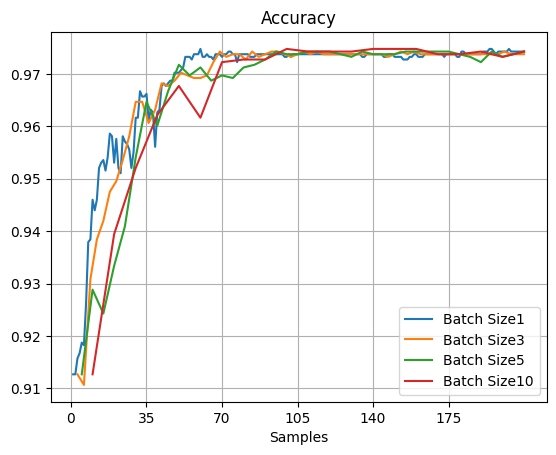

In [23]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, accuracy_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Accuracy')
plt.legend(loc='best')
plt.show()

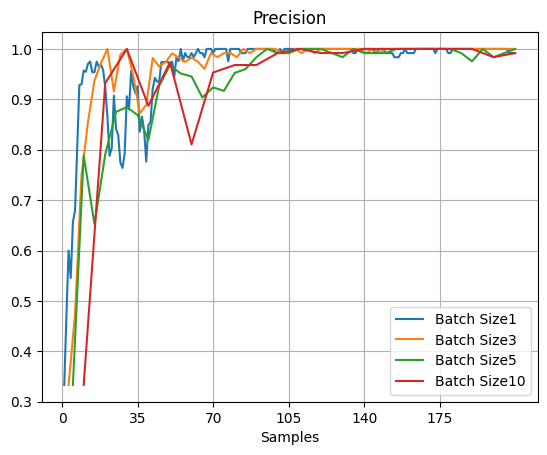

In [24]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, precision_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Precision')
plt.legend(loc='best')
plt.show()

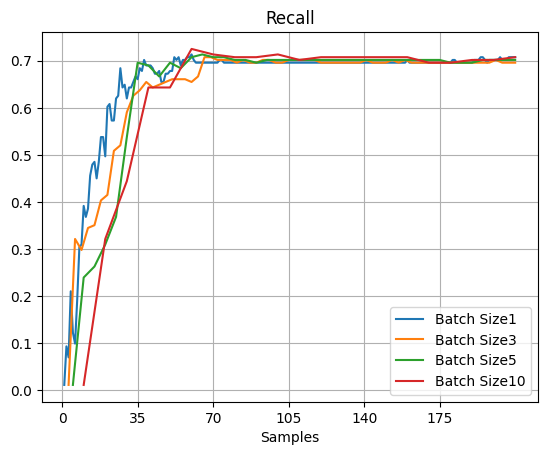

In [25]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, recall_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Recall')
plt.legend(loc='best')
plt.show()

# Active Learning with Abstention

In [28]:
def pred_with_abst(y_test, pred_probs):
    ''' Takes in the actualy labels and predictions.
        Returns the predictions and labels with abstention applied and the abstention count. '''
    X_idx = []
    predictions = []
    y_test_abst = []
    abstention_count = 0
    for j in range(len(pred_probs)):
            if np.max(pred_probs[j]) < ABSTENTION_THRESHOLD:
                abstention_count += 1
            else:
                X_idx.append(j)
                y_test_abst.append(y_test[j])
                predictions.append(np.argmax(pred_probs[j]))
    return np.array(predictions), np.array(y_test_abst), np.array(X_idx), abstention_count

## Entropy Sampling

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)

accuracy_final = []
precision_final = []
recall_final = []
abstention_final = []
epoch_final = []
learner2_list = []

for batch_size in tqdm(BATCH_SIZES):
    epoch = EPOCHS // batch_size
    X_init, X_pool, y_init, y_pool = train_test_split(X_train, y_train, test_size=(len(X_train)-20)/len(X_train), random_state=SEED, stratify=y_train)

    learner = ActiveLearner(
            estimator=RandomForestClassifier(n_estimators=ESTIMATORS, random_state=SEED),
            query_strategy=entropy_sampling,
            X_training=X_init, y_training=y_init
            )
    
    pred_probs = learner.predict_proba(X_test)
    predictions, y_test_abst, _, abst_count = pred_with_abst(y_test, pred_probs)

    acc = accuracy_score(y_test_abst, predictions)
    precision = precision_score(y_test_abst, predictions, zero_division=0)
    recall = recall_score(y_test_abst, predictions)

    accuracy_scores = [acc]
    precision_scores = [precision]
    recall_scores = [recall]
    abstention_score = [abst_count]
    epochs = [1]

    for i in range(2, epoch+1):
        # Get certainty of predictions
        probs = learner.predict_proba(X_pool)
        certainties = np.max(probs, axis=1)
        
        # Find out candidates (samples where model has, at least, a given certainty)
        candidates = certainties <= ABSTENTION_THRESHOLD
        if np.sum(candidates) < batch_size:
            print("Threshold reached, no more training")
            break

        query_idx, query_instances = learner.query(X_pool, n_instances=batch_size)

        # Retrieve batch of samples and train the model on them
        y_batch = y_pool[query_idx]
        learner.teach(X=query_instances, y=y_batch)

        # Remove queried samples from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Make predictions and compute abstentions
        pred_probs = learner.predict_proba(X_test)
        predictions, y_test_abst, _, abst_count = pred_with_abst(y_test, pred_probs)
                
        # Evaluate performance post-abstention        
        acc = accuracy_score(y_test_abst, predictions)
        precision = precision_score(y_test_abst, predictions, zero_division=0)
        recall = recall_score(y_test_abst, predictions)
            
        # Store results for plotting
        epochs.append(i)
        accuracy_scores.append(acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        abstention_score.append(abst_count)
    learner2_list.append(learner)

    acc = accuracy_scores[-1]
    precision = precision_scores[-1]
    recall = recall_scores[-1]
    abstention = abstention_score[-1]

    accuracy_final.append(accuracy_scores)
    precision_final.append(precision_scores)
    recall_final.append(recall_scores)
    abstention_final.append(abstention_score)
    epoch_final.append(epochs)

    print(f"Batch size: {batch_size} | Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Abstention: {abst_count}")

 25%|██▌       | 1/4 [01:46<05:20, 106.77s/it]

Batch size: 1 | Accuracy: 0.9772, Precision: 1.0000, Recall: 0.6587, Abstention: 93


 50%|█████     | 2/4 [02:28<02:17, 68.65s/it] 

Batch size: 3 | Accuracy: 0.9745, Precision: 1.0000, Recall: 0.6951, Abstention: 22


 75%|███████▌  | 3/4 [02:48<00:46, 46.17s/it]

Batch size: 5 | Accuracy: 0.9763, Precision: 1.0000, Recall: 0.6974, Abstention: 43


100%|██████████| 4/4 [02:57<00:00, 44.45s/it]

Batch size: 10 | Accuracy: 0.9781, Precision: 1.0000, Recall: 0.7192, Abstention: 109


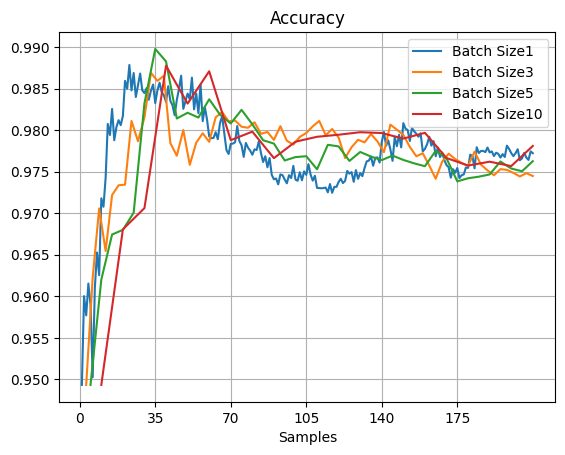

In [31]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, accuracy_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Accuracy')
plt.legend(loc='best')
plt.show()

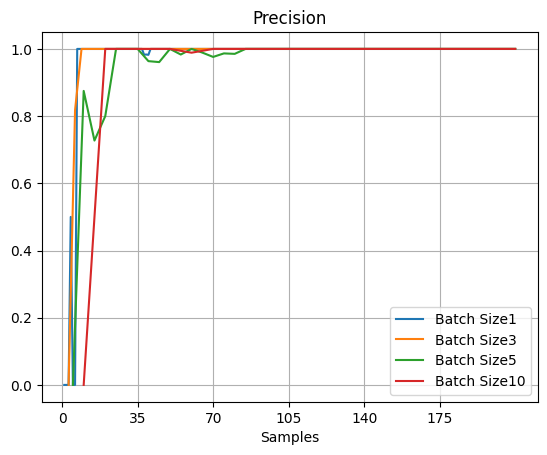

In [32]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, precision_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Precision')
plt.legend(loc='best')
plt.show()

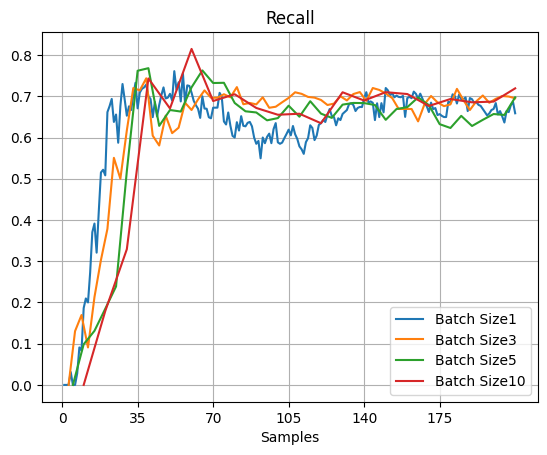

In [33]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, recall_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Recall')
plt.legend(loc='best')
plt.show()

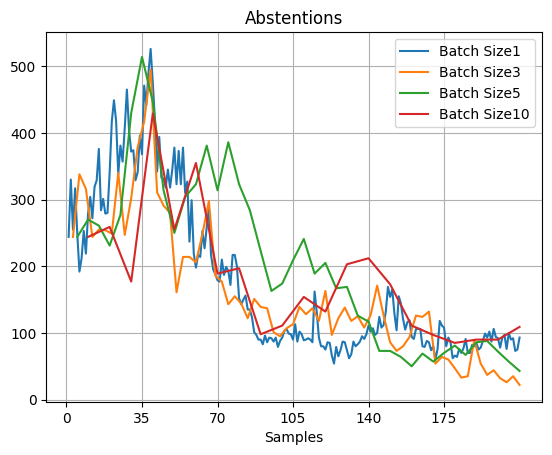

In [34]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, abstention_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Abstentions')
plt.legend(loc='best')
plt.show()

## Committee

In [36]:
X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)

accuracy_final = []
precision_final = []
recall_final = []
abstention_final = []
epoch_final = []
committee_list = []

for batch_size in tqdm(BATCH_SIZES):
    epoch = EPOCHS // batch_size
    learner_list = []
    
    for member_idx in range(N_MEMBERS):
        X_init, X_pool, y_init, y_pool = train_test_split(X_pool, y_pool, test_size=(len(X_pool)-20)/len(X_pool), random_state=SEED, stratify=y_pool)
        
        # Each learner gets 20 initial training samples
        learner = ActiveLearner(
            estimator=RandomForestClassifier(n_estimators=40+member_idx*15, random_state=SEED),
            query_strategy=entropy_sampling,
            X_training=X_init, y_training=y_init
        )
        learner_list.append(learner)
        
    committee = Committee(learner_list=learner_list,
                        query_strategy=vote_entropy_sampling)

    pred_probs = committee.predict_proba(X_test)
    predictions, y_test_abst, _, abst_count = pred_with_abst(y_test, pred_probs)

    acc = accuracy_score(y_test_abst, predictions)
    precision = precision_score(y_test_abst, predictions, zero_division=0)
    recall = recall_score(y_test_abst, predictions)

    accuracy_scores = [acc]
    precision_scores = [precision]
    recall_scores = [recall]
    abstention_score = [abst_count]
    epochs = [1]

    for i in tqdm(range(2, epoch+1)):
        # Get certainty of predictions
        probs = committee.predict_proba(X_pool)
        certainties = np.max(probs, axis=1)
        
        # Find out candidates (samples where model has, at least, a given certainty)
        candidates = certainties <= ABSTENTION_THRESHOLD
        if np.sum(candidates) < batch_size:
            print("Threshold reached, no more training")
            break

        query_idx, query_instances = committee.query(X_pool, n_instances=batch_size)

        # Retrieve batch of samples and train the model on them
        y_batch = y_pool[query_idx]
        committee.teach(X=query_instances, y=y_batch)

        # Remove queried samples from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Make predictions and compute abstentions
        pred_probs = committee.predict_proba(X_test)
        predictions, y_test_abst, _, abst_count = pred_with_abst(y_test, pred_probs)
                
        # Evaluate performance post-abstention        
        acc = accuracy_score(y_test_abst, predictions)
        precision = precision_score(y_test_abst, predictions, zero_division=0)
        recall = recall_score(y_test_abst, predictions)
            
        # Store results for plotting
        epochs.append(i)
        accuracy_scores.append(acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        abstention_score.append(abst_count)
    committee_list.append(committee)

    acc = accuracy_scores[-1]
    precision = precision_scores[-1]
    recall = recall_scores[-1]
    abstention = abstention_score[-1]

    accuracy_final.append(accuracy_scores)
    precision_final.append(precision_scores)
    recall_final.append(recall_scores)
    abstention_final.append(abstention_score)
    epoch_final.append(epochs)

    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Abstention: {abst_count}")

 25%|██▌       | 1/4 [10:59<32:57, 659.18s/it]

Accuracy: 0.9756, Precision: 1.0000, Recall: 0.6594, Abstention: 56


 50%|█████     | 2/4 [14:05<12:41, 380.96s/it]

Accuracy: 0.9772, Precision: 1.0000, Recall: 0.6966, Abstention: 49


 75%|███████▌  | 3/4 [16:04<04:21, 261.24s/it]

Accuracy: 0.9755, Precision: 1.0000, Recall: 0.6824, Abstention: 59


100%|██████████| 4/4 [16:43<00:00, 250.95s/it]

Accuracy: 0.9753, Precision: 1.0000, Recall: 0.6522, Abstention: 35


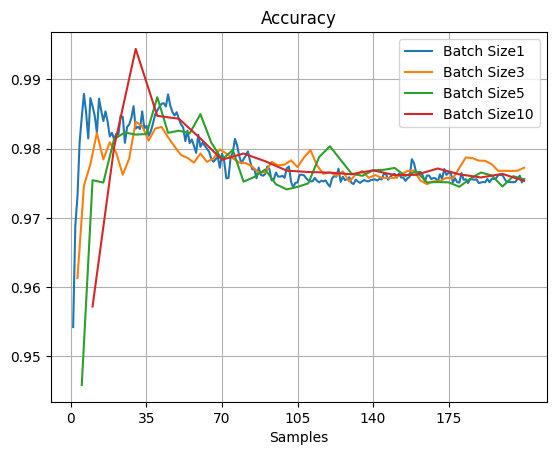

In [37]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, accuracy_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Accuracy')
plt.legend(loc='best')
plt.show()

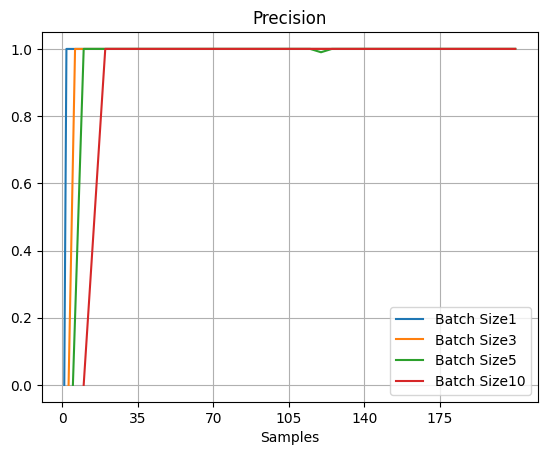

In [38]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, precision_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Precision')
plt.legend(loc='best')
plt.show()

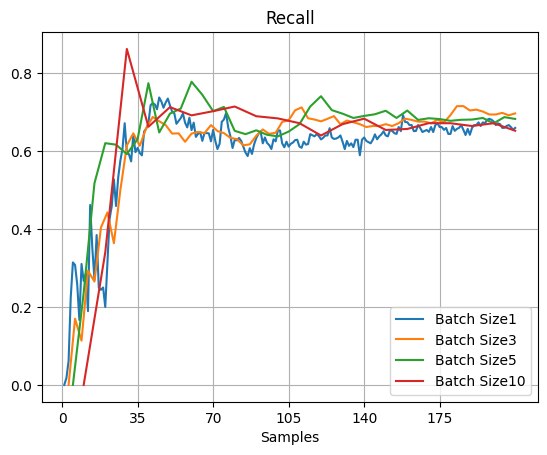

In [39]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, recall_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Recall')
plt.legend(loc='best')
plt.show()

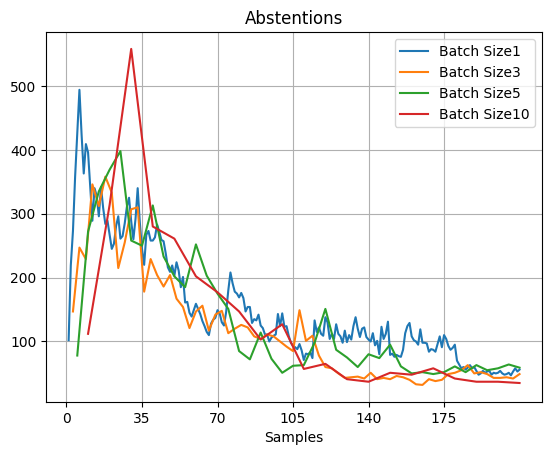

In [41]:
for i in range(0, len(BATCH_SIZES)):
    batch_size = BATCH_SIZES[i]
    epoch_n = [x * batch_size for x in epoch_final[i]]
    plt.plot(epoch_n, abstention_final[i], label=f'Batch Size{batch_size}')

plt.xlabel('Samples')
plt.xticks(range(0, epoch_n[-1], epoch_n[-1]//6))
plt.grid(True)
plt.title('Abstentions')
plt.legend(loc='best')
plt.show()

## Explainability (for entropy sampling)

In [42]:
# Create a dataframe with test set metadata
df_test = pd.DataFrame(X_test, columns=df.columns[:-1])

# Explainer interface for explaining the active learning models through Shapley values
explainer1 = shap.TreeExplainer(learner2_list[0].estimator)
explainer3 = shap.TreeExplainer(learner2_list[1].estimator)
explainer5 = shap.TreeExplainer(learner2_list[2].estimator)
explainer10 = shap.TreeExplainer(learner2_list[3].estimator)

# Obtain an explanation for the test dataset (SHAP values)
shap_values1 = explainer1(df_test)
shap_values3 = explainer3(df_test)
shap_values5 = explainer5(df_test)
shap_values10 = explainer10(df_test)

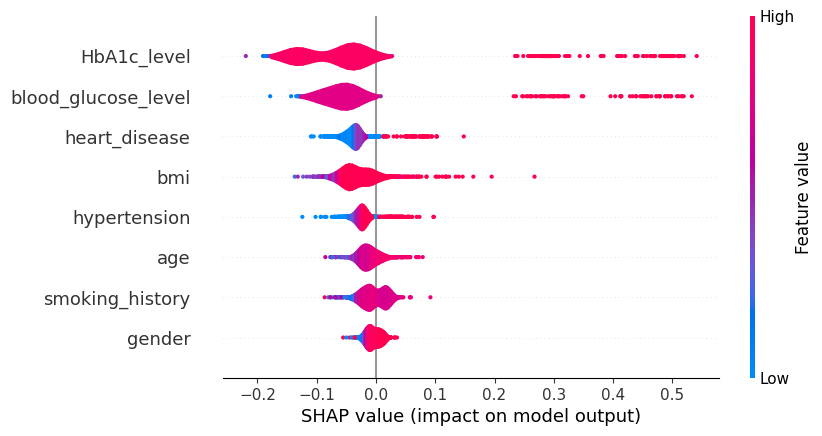

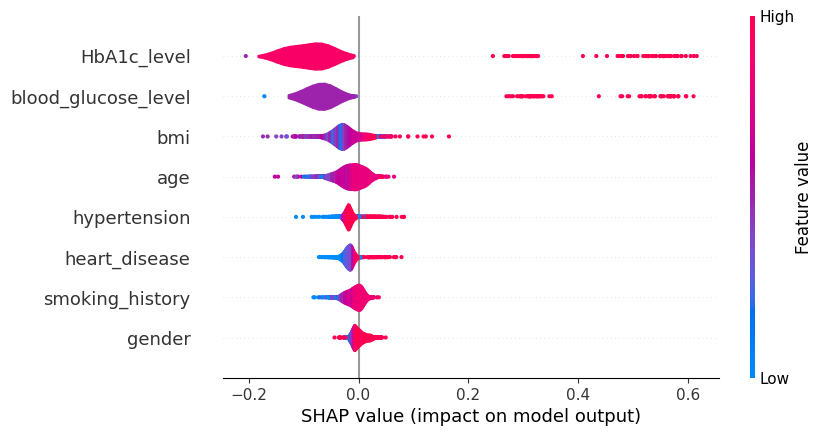

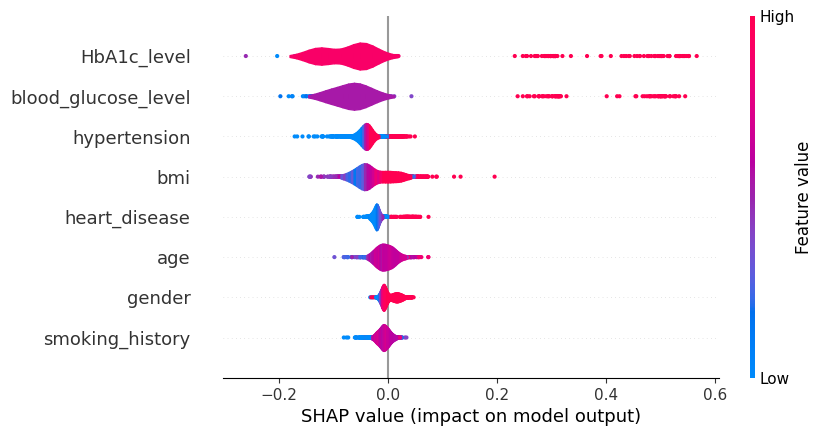

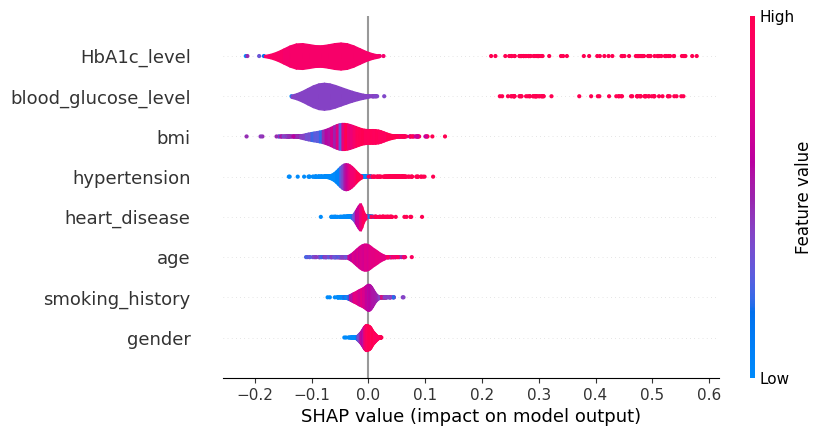

In [43]:
# Plotting feature importance
shap.plots.violin(shap_values1.values[..., 1], features=df_test, feature_names=df_test.columns)
shap.plots.violin(shap_values3.values[..., 1], features=df_test, feature_names=df_test.columns)
shap.plots.violin(shap_values5.values[..., 1], features=df_test, feature_names=df_test.columns)
shap.plots.violin(shap_values10.values[..., 1], features=df_test, feature_names=df_test.columns)

In [44]:
# Get the indices of the test samples with class 1
class1_idx = np.where(y_test == 1)[0]

# Create a dataframe with test set metadata for class 1 samples
df_test_1 = pd.DataFrame(X_test[class1_idx], columns=df.columns[:-1])

# Explain the active learning models' predictions through SHAP values
shap_values1_1 = explainer1(df_test_1)
shap_values3_1 = explainer3(df_test_1)
shap_values5_1 = explainer5(df_test_1)
shap_values10_1 = explainer10(df_test_1)

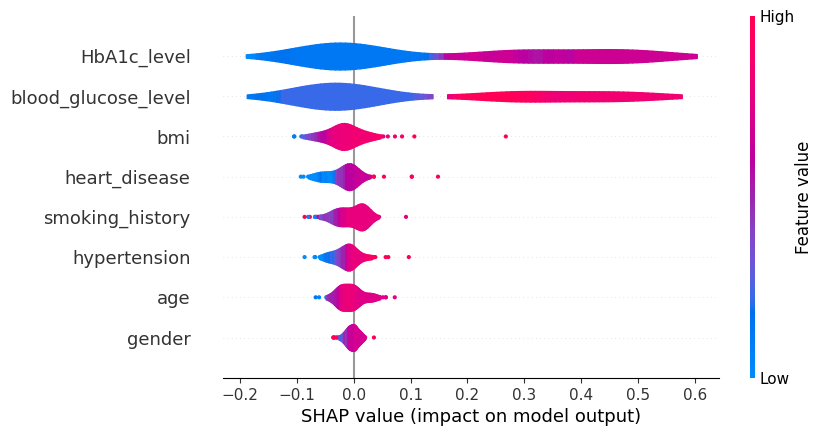

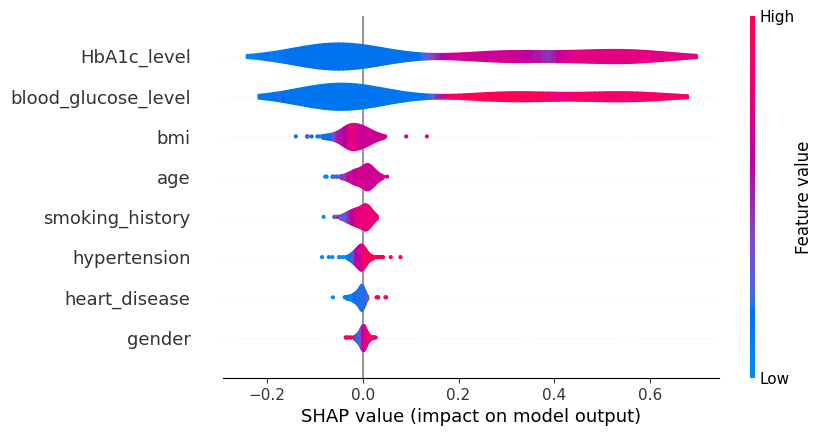

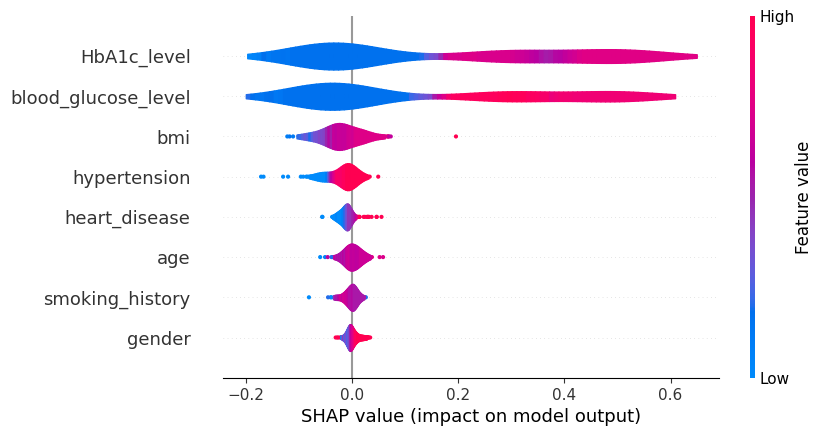

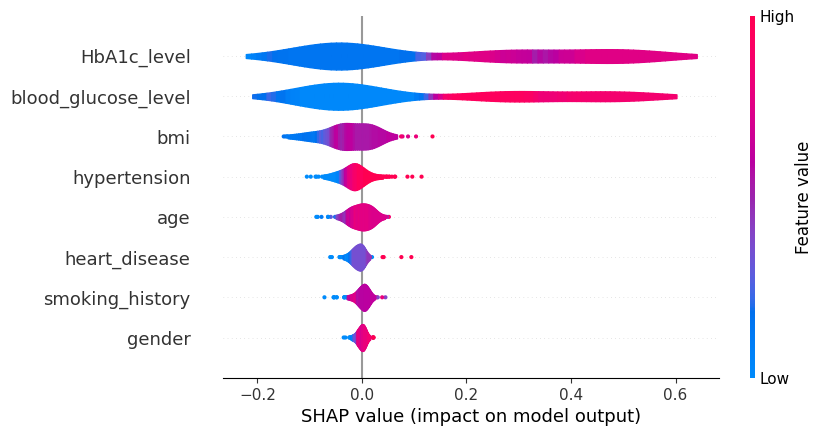

In [45]:
# Plotting feature importance
shap.plots.violin(shap_values1_1.values[..., 1], features=df_test_1, feature_names=df_test_1.columns)
shap.plots.violin(shap_values3_1.values[..., 1], features=df_test_1, feature_names=df_test_1.columns)
shap.plots.violin(shap_values5_1.values[..., 1], features=df_test_1, feature_names=df_test_1.columns)
shap.plots.violin(shap_values10_1.values[..., 1], features=df_test_1, feature_names=df_test_1.columns)

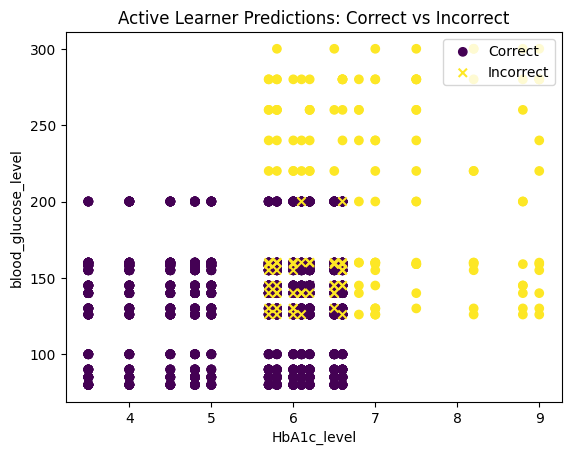

In [46]:
''' GPT aided '''

# Get the 2 "most important features"
X_test_2d = X_test[:, -2:]

# Get predictions from active learner with batch size 1
preds = learner2_list[0].predict(X_test)

# Identify correctly and incorrectly classified samples
correct = preds == y_test
incorrect = preds != y_test

# Plot the correctly classified examples (ticks)
plt.scatter(
    X_test_2d[correct, 0], X_test_2d[correct, 1],
    c=y_test[correct],
    marker='o',  # Circle for correct
    label='Correct'
)

# Plot the incorrectly classified examples (crosses)
plt.scatter(
    X_test_2d[incorrect, 0], X_test_2d[incorrect, 1],
    c=y_test[incorrect],
    marker='x',  # Cross for incorrect
    label='Incorrect'
)

# Add labels, legend, and title
plt.xlabel('HbA1c_level')
plt.ylabel('blood_glucose_level')
plt.title('Active Learner Predictions: Correct vs Incorrect')
plt.legend(loc='upper right')
plt.show()

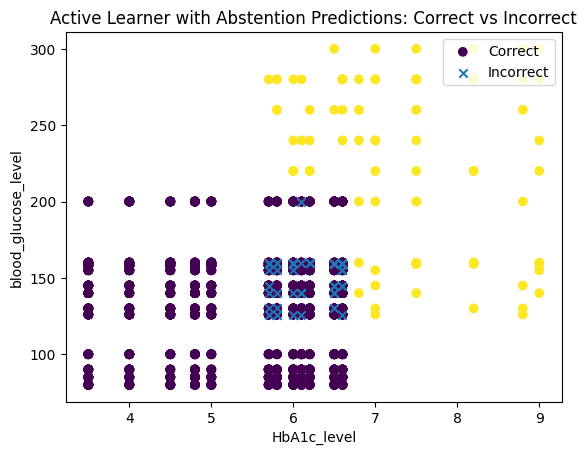

In [47]:
''' GPT aided '''

# Get the 2 "most important features"
X_test_2d = X_test[:, -2:]

# Get predictions from active learner with batch size 1
pred_probs = learner2_list[0].predict_proba(X_test)
preds, y_test_new, X_idx, _ = pred_with_abst(y_test, pred_probs)

# Get X_test idxs of non-abstained instances
X_test_2d_new = X_test_2d[X_idx]

# Identify correctly and incorrectly classified samples
correct = preds == y_test_new
incorrect = preds != y_test_new

# Plot the correctly classified examples (ticks)
plt.scatter(
    X_test_2d_new[correct, 0], X_test_2d_new[correct, 1],
    c=y_test_new[correct],
    marker='o',  # Circle for correct
    label='Correct'
)

# Plot the incorrectly classified examples (crosses)
plt.scatter(
    X_test_2d_new[incorrect, 0], X_test_2d_new[incorrect, 1],
    marker='x',  # Cross for incorrect
    label='Incorrect'
)

# Add labels, legend, and title
plt.xlabel('HbA1c_level')
plt.ylabel('blood_glucose_level')
plt.title('Active Learner with Abstention Predictions: Correct vs Incorrect')
plt.legend(loc='upper right')
plt.show()

In [48]:
# Prediction explanation for batch size 1
shap.plots.force(explainer1.expected_value[0], shap_values1.values[..., 1], X_test, feature_names=df_test.columns)

In [49]:
# Prediction explanation for batch size 3
shap.plots.force(explainer3.expected_value[0], shap_values3.values[..., 1], X_test, feature_names=df_test.columns)

In [50]:
# Prediction explanation for batch size 5
shap.plots.force(explainer5.expected_value[0], shap_values5.values[..., 1], X_test, feature_names=df_test.columns)

In [51]:
# Prediction explanation for batch size 10
shap.plots.force(explainer.expected_value[0], shap_values10.values[..., 1], X_test, feature_names=df_test.columns)

#### Extra: Prediction plot for committee

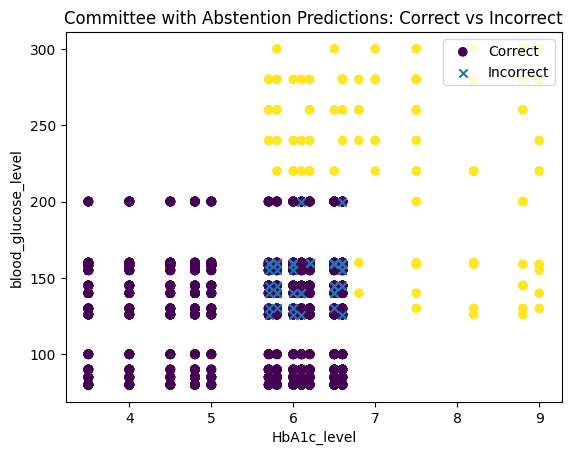

In [52]:
''' GPT aided '''

# Get the 2 "most important features"
X_test_2d = X_test[:, -2:]

# Get predictions from active learner with batch size 1
pred_probs = committee_list[0].predict_proba(X_test)
preds, y_test_new, X_idx, _ = pred_with_abst(y_test, pred_probs)

# Get X_test idxs of non-abstained instances
X_test_2d_new = X_test_2d[X_idx]

# Identify correctly and incorrectly classified samples
correct = preds == y_test_new
incorrect = preds != y_test_new

# Plot the correctly classified examples (ticks)
plt.scatter(
    X_test_2d_new[correct, 0], X_test_2d_new[correct, 1],
    c=y_test_new[correct],
    marker='o',  # Circle for correct
    label='Correct'
)

# Plot the incorrectly classified examples (crosses)
plt.scatter(
    X_test_2d_new[incorrect, 0], X_test_2d_new[incorrect, 1],
    marker='x',  # Cross for incorrect
    label='Incorrect'
)

# Add labels, legend, and title
plt.xlabel('HbA1c_level')
plt.ylabel('blood_glucose_level')
plt.title('Committee with Abstention Predictions: Correct vs Incorrect')
plt.legend(loc='upper right')
plt.show()